<a href="https://colab.research.google.com/gist/jteichma/f0df299304472502462555a438ea29e6/lsv_calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Calibration: enter a new modelling paradigm via neural models

We exemplify this approach in the case of local stochastic volatility models, some information can also be found in a [talk from Stockholm](https://people.math.ethz.ch/~jteichma/talk_stockholm_2019.pdf).

Local stochastic volatility models are an extension of local volatility models, which considerably improve their econometric and dynamic properties.

A local volatility model is a model of the type
$$
d S_t = \sigma(t,S_t) S_t dW_t
$$
for some initial price $S_0$ and some \emph{local volatility function} $ (t,S) \mapsto \sigma(t,S) $. It goes back to Bruno Dupire's groundbreaking article [Pricing with a smile](https://web.archive.org/web/20120907114056/http://www.risk.net/data/risk/pdf/technical/2007/risk20_0707_technical_volatility.pdf), where essentially the [Breeden-Litzenberger formula](http://efinance.org.cn/cn/fe/Prices%20of%20State-Contingent%20Claims%20Implicit%20in%20Option%20Prices.pdf) is used. This formula asserts that
$$
\partial^2_K C(T,K) dK = p_T(K) dK = \mathrm{law}(S_T)(dK)
$$
for European option prices $ C(T,K) $ in an interest-rate free market environment: in other words one can calculate the risk-neutral density of the price process from option prices.

The derivation is -- besides technical details -- easy: the Fokker-Planck equation, which is an equation in the forward variable (and not in $S_0$!), asserts that
$$
\partial_T p_T(S) = \frac{1}{2} \partial_S^2 (S^2 \sigma^2(T,S) p_T(S))
$$
holds true. Consider now the pairing of this equation with $ (. - K)_+ $, then it reads
$$
\partial_T C(T,K) = \frac{1}{2} \int \partial_S^2 \big( S^2 \sigma(T,S) p_T(S) \big) (S-K)_+ dS \, .
$$
Applying twice integration by parts leads via the Breeden-Litzenberger formula to
$$
\partial_T C(T,K) = \frac{1}{2} \int S^2 \sigma^2(T,S) p_T(S) \delta_K(dS) = \frac{1}{2}\sigma^2(T,K) K^2 \partial_K^2 C(T,K) \, .
$$
The Dupire formula for local volatility
$$
\sigma^2_{\text{Dupire}}(T,K) = \frac{2 \partial_T C(T,K)}{K^2 \partial_K^2 C(T,K)}
$$
therefore yields a local volatility model which produces precisely the prices $C(T,K)$ for European options with maturity $ T $ and strike price $ K $.

Now we have to answer a second question: imagine that we have a local volatility model
$$
d \tilde S_t = \tilde S_t \sigma_{\text{Dupire}}(t,\tilde S_t) dW_t
$$
and a second model, a so called local stochastic volatility model with leverage function $l$ and some exogenous process $ \alpha $ given on the same stochastic basis
$$
dS_t = S_t \alpha_t l(t,S_t) dW_t
$$
and with initial value $ S_0 $ each. When do both models have the same marginal distributions for every time $ T \geq 0 $, in other words, when do the prices of European call options coincide? This is clearly the case when both models behave stochastically at each point in time the same, which is the case when the conditional variances at any point $S_T$ for each $ T \geq 0 $ coincide, i.e.
$$
E \big[ \alpha_t^2 l^2(t,S_t) S_t^2 | S_t = x \big] = l^2(T,x) x^2 E \big[ \alpha_t^2 | S_t = x \big] = \sigma_{\text{Dupire}}^2(t,x) x^2 \, .
$$
Therefore the analogue to Dupire's formula in the case of local stochastic volatility models is
$$
d S_t = S_t \alpha_t \frac{\sigma_{\text{Dupire}}(t,S_t)}{\sqrt{E[\alpha^2_t | S_t = x]|_{x=S_t}}} d W_t \, .
$$
This is the McKean-Vlasov-version of the local stochastic volatility model of Pierre Henry-Labordere paper [Calibration of local stochastic volatility models to Market smiles: a Monte-Carlo approach](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1493306).

We take a different road here and do not derive particle methods to solve the McKean-Vlasov equation but rather parametrize the leverage function $l$ by neural networks. This corresponds to writing directly neural network models and learning them to fulfill tasks.

We can set up the problem to infer the local volatility function $ l $ from derivativess' prices in the following machine learning fashion: try to find a function $ l $, given via neural networks and hedges $ H^{(K,T)} $ such that
$$
\sum_{(K,T)} {\Big[E\big[(S_T-K)_+ - C_{\text{market}}(K,T) - (H^{(K,T)}\bullet S)_T \big]\Big]}^2 \rightarrow \text{min!} \, .
$$
Notice that the sum is running over a finite set of price data points. The hedges, also given by neural networks, are improved according to
$$
\sum_{(K,T)} E\big[{((S_T-K)_+ - C_{\text{market}}(K,T) - (H^{(K,T)}\bullet S)_T )}^2 \big] \rightarrow \text{min!} \, .
$$
Notice the the difference in the place of the expectation. The problem can possibly solve the calibration problem but one has to learn the leverage function and the hedges simultanously with respect to \emph{different} loss functions.

Let us see in the sequel if this can work out. We shall use notation which reminds the above formulation.

In [6]:
#%tensorflow_version 1.x

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import numpy as np
#import tensorflow as tf

from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Concatenate, Dropout, Subtract, \
                        Flatten, MaxPooling2D, Multiply, Lambda, Add, Dot
from keras.backend import constant
from keras import optimizers

from keras.models import Model
from keras.layers import Input
from keras import initializers
from keras.constraints import max_norm
import keras.backend as K

Instructions for updating:
non-resource variables are not supported in the long term


First we create two identical models where either only hedges or local volatilities can be trained.

In [7]:
m = 10 # layer dimension
n = 2 # number of layers for local volatility
N = 20 # time discretization (should fit to maturities)
maturities = [0.5, 1.] # list of maturities in years

T = 1.0

layers = []
for j in range(len(maturities)):
    layersatT = []
    for i in range(n):
        if i < 1:
            nodes = m
        else:
            nodes = 1
        layer = Dense(nodes, activation='relu', trainable=False,
                      kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                      bias_initializer='random_normal')
        layersatT = layersatT + [layer]
    layers = layers + [layersatT]

#P = {(1.0,1.0): 0.4, (1.1,1.0):0.2, (0.9,1.0):0.5, 
#     (1.0,0.5): 0.2, (1.1,0.5):0.1, (0.9,0.5):0.3}

P= {(0.9, 0.5): 0.20042534,
    (0.9, 1.0): 0.23559685,
    (1.0, 0.5): 0.16312157,
    (1.0, 1.0): 0.20771958,
    (1.1, 0.5): 0.13154241,
    (1.1, 1.0): 0.18236567}

hedges = {}
hedgeskey =[]
for key in P.keys():
    for j in range(N):
        hedge = Dense(nodes, activation='relu', trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,0.1),#kernel_initializer='random_normal',
                      bias_initializer='random_normal')
        hedgeskey = hedgeskey + [hedge]
    hedges[key] = hedgeskey
start = 0

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
keylist = list(P.keys())
price = Input(shape=(1,))
hedgepf = [Input(shape=(1,)) for l in range(len(P.keys()))]
inputs = [price] + hedgepf
inputshelper = []
hedgeratio = {}
hedge = {}
pricekey = [0 for l in range(len(P.keys()))]

normal = tf.distributions.Normal(loc=0., scale=1.)

def BS(x):
    price=x[0]
    vola=x[1]
    return normal.cdf((K.log(K.abs(price)/key[0])-0.5*(key[1]-j*T/N)*vola**2)/(0.00001+np.sqrt(key[1]-j*T/N)*vola))
# increases computational time

for i in range(len(maturities)):
    for j in range(start,N):
        if maturities[i] >= j*T/N:
            helper0 = layers[i][0](price)
            for k in range(1,2):
                helper0 = layers[i][k](helper0) # local vol applied to price at time j*T/N
            BMincr = Input(shape=(1,)) # BM increment
            stochvol = Input(shape=(1,)) # stochvol value
            helper1 = Multiply()([helper0,BMincr])
            helper1 = Lambda(lambda x: x * np.sqrt(T/N))(helper1)
            priceincr = Multiply()([helper1,stochvol]) # new price increment
            for l in range(len(P.keys())):
                key = keylist[l]
                hedgeratio[key] = hedges[key][j](price)
                BSstrategy = Lambda(BS)([price,helper0])
                hedgeratio[key] = Add()([hedgeratio[key],BSstrategy])
                hedge[key] = Multiply()([priceincr,hedgeratio[key]])
                hedgepf[l] = Add()([hedgepf[l],hedge[key]])
                if key[1]==((j+1)*T/N): # the option expires
                    helper2 = Lambda(lambda x : 0.5*(abs(x-key[0])+x-key[0]))(price)
                    helper2 = Subtract()([helper2,hedgepf[l]]) # payoff minus hedge 
                    pricekey[l] = helper2
            price = Add()([price,priceincr]) #new price after one time step
            inputshelper = inputshelper + [stochvol]
            inputs = inputs + [BMincr]
        else:
            start = j
            break

inputs = inputs + inputshelper
pricekey = Concatenate()(pricekey)
localvol_trainhedge = Model(inputs=inputs, outputs=pricekey)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
<ipython-input-8-a0d2ebc90d3a>:15: RuntimeWarning: invalid value encountered in sqrt
  return normal.cdf((K.log(K.abs(price)/key[0])-0.5*(key[1]-j*T/N)*vola**2)/(0.00001+np.sqrt(key[1]-j*T/N)*vola))


Pay attention here: don't jump back and forth when defining models since layer lists come with the same names, so the order of execution is important!

In [9]:
layers = []

for j in range(len(maturities)):
    layersatT = []
    for i in range(2):
        if i < 1:
            nodes = m
        else:
            nodes = 1
        layer = Dense(nodes, activation='relu', trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                      bias_initializer='random_normal')
        layersatT = layersatT + [layer]
    layers = layers + [layersatT]


hedges = {}
hedgeskey =[]
for key in P.keys():
    for j in range(N):
        hedge = Dense(nodes, activation='relu', trainable=False,
                      kernel_initializer=initializers.RandomNormal(0,0.1),#kernel_initializer='random_normal',
                      bias_initializer='random_normal')
        hedgeskey = hedgeskey + [hedge]
    hedges[key] = hedgeskey
start = 0

In [10]:
keylist = list(P.keys())
price = Input(shape=(1,))
hedgepf = [Input(shape=(1,)) for l in range(len(P.keys()))]
inputs = [price] + hedgepf
inputshelper = []
hedgeratio = {}
hedge = {}
pricekey = [0 for l in range(len(P.keys()))]

for i in range(len(maturities)):
    for j in range(start,N):
        if maturities[i] >= j*T/N:
            layers[i][0].trainable=True
            helper0 = layers[i][0](price)
            for k in range(1,2):
                layers[i][k].trainable=True
                helper0 = layers[i][k](helper0)
            BMincr = Input(shape=(1,))
            stochvol = Input(shape=(1,))
            helper1 = Multiply()([helper0,BMincr])
            helper1 = Lambda(lambda x: x * np.sqrt(T/N))(helper1)
            priceincr = Multiply()([helper1,stochvol])
            for l in range(len(P.keys())):
                key = keylist[l]
                hedges[key][j].trainable=False
                hedgeratio[key] = hedges[key][j](price)
                BSstrategy = Lambda(BS)([price,helper0])
                hedgeratio[key] = Add()([hedgeratio[key],BSstrategy])
                hedge[key] = Multiply()([priceincr,hedgeratio[key]])
                hedgepf[l] = Add()([hedgepf[l],hedge[key]])
                if key[1]==((j+1)*T/N):
                    helper2 = Lambda(lambda x : 0.5*(abs(x-key[0])+x-key[0]))(price)
                    helper2 = Subtract()([helper2,hedgepf[l]])
                    pricekey[l] = helper2 
            price = Add()([price,priceincr])
            inputshelper = inputshelper + [stochvol]
            inputs = inputs + [BMincr]
        else:
            start = j
            break

inputs = inputs + inputshelper
pricekey = Concatenate()(pricekey)
localvol_trainlocvol = Model(inputs=inputs, outputs=pricekey)

<ipython-input-8-a0d2ebc90d3a>:15: RuntimeWarning: invalid value encountered in sqrt
  return normal.cdf((K.log(K.abs(price)/key[0])-0.5*(key[1]-j*T/N)*vola**2)/(0.00001+np.sqrt(key[1]-j*T/N)*vola))


In [11]:
#localvol_trainlocvol.summary()

Here we use a very small amount of trajectories due to the variance reduction coming from hedges just for purposes of illustration even though it already works relatively well. Below we consecutively train hedges or local volatilities.

In [12]:
Ltrain = 5*10**3

xtrain =([np.ones(Ltrain)] + [np.zeros(Ltrain) for key in keylist]+
         [np.random.normal(0,1,Ltrain) for i in range(N)]+
         [np.ones(Ltrain) for i in range(N)])

ytrain=np.zeros((Ltrain,len(P.keys())))
for i in range(Ltrain):
    for l in range(len(P.keys())):
        key = keylist[l]
        ytrain[i,l]= P[key]

In the sequel the actual training is performed:

Train on 5000 samples
Epoch 1/15
5000/5000 [==============================] - 7s 1ms/sample - loss: 10.2618
Epoch 2/15
5000/5000 [==============================] - 2s 369us/sample - loss: 7.1151
Epoch 3/15
5000/5000 [==============================] - 2s 388us/sample - loss: 5.5581
Epoch 4/15
5000/5000 [==============================] - 2s 360us/sample - loss: 4.9405
Epoch 5/15
5000/5000 [==============================] - 3s 577us/sample - loss: 4.7359
Epoch 6/15
5000/5000 [==============================] - 2s 408us/sample - loss: 4.6483
Epoch 7/15
5000/5000 [==============================] - 2s 359us/sample - loss: 4.6172
Epoch 8/15
5000/5000 [==============================] - 2s 366us/sample - loss: 4.6158
Epoch 9/15
5000/5000 [==============================] - 2s 354us/sample - loss: 4.5794
Epoch 10/15
5000/5000 [==============================] - 2s 369us/sample - loss: 4.5990
Epoch 11/15
5000/5000 [==============================] - 2s 471us/sample - loss: 4.5423
Epoch 12/15
5000/500

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


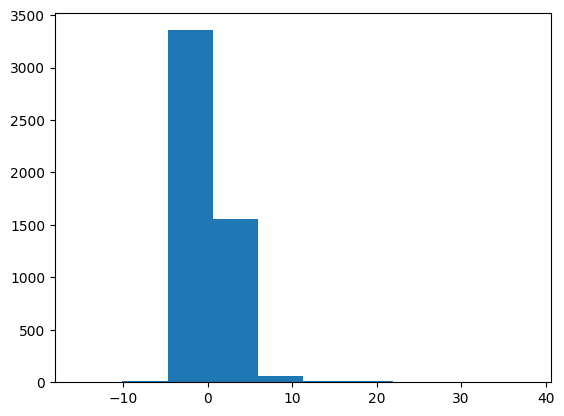

0.66538477
Train on 5000 samples
Epoch 1/15
5000/5000 [==============================] - 2s 401us/sample - loss: 0.0274
Epoch 2/15
5000/5000 [==============================] - 2s 390us/sample - loss: 0.0274
Epoch 3/15
5000/5000 [==============================] - 2s 393us/sample - loss: 0.0273
Epoch 4/15
5000/5000 [==============================] - 2s 387us/sample - loss: 0.0273
Epoch 5/15
5000/5000 [==============================] - 3s 512us/sample - loss: 0.0273
Epoch 6/15
5000/5000 [==============================] - 2s 495us/sample - loss: 0.0272
Epoch 7/15
5000/5000 [==============================] - 2s 378us/sample - loss: 0.0272
Epoch 8/15
5000/5000 [==============================] - 2s 389us/sample - loss: 0.0271
Epoch 9/15
5000/5000 [==============================] - 2s 384us/sample - loss: 0.0271
Epoch 10/15
5000/5000 [==============================] - 2s 384us/sample - loss: 0.0270
Epoch 11/15
5000/5000 [==============================] - 3s 521us/sample - loss: 0.0270
Epoch 12

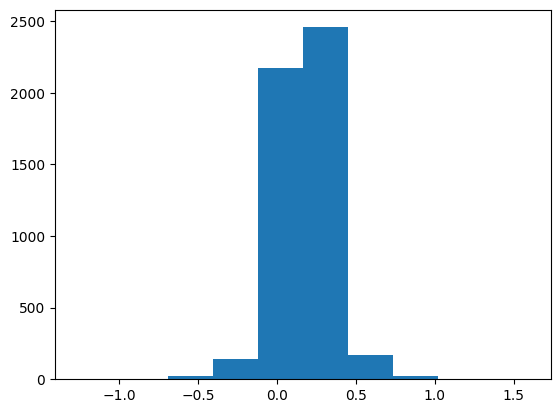

0.17499617
Train on 5000 samples
Epoch 1/15
5000/5000 [==============================] - 2s 391us/sample - loss: 0.0166
Epoch 2/15
5000/5000 [==============================] - 2s 396us/sample - loss: 0.0166
Epoch 3/15
5000/5000 [==============================] - 3s 628us/sample - loss: 0.0166
Epoch 4/15
5000/5000 [==============================] - 2s 396us/sample - loss: 0.0166
Epoch 5/15
5000/5000 [==============================] - 2s 405us/sample - loss: 0.0166
Epoch 6/15
5000/5000 [==============================] - 2s 401us/sample - loss: 0.0165
Epoch 7/15
5000/5000 [==============================] - 2s 406us/sample - loss: 0.0165
Epoch 8/15
5000/5000 [==============================] - 2s 430us/sample - loss: 0.0165
Epoch 9/15
5000/5000 [==============================] - 3s 592us/sample - loss: 0.0165
Epoch 10/15
5000/5000 [==============================] - 2s 397us/sample - loss: 0.0164
Epoch 11/15
5000/5000 [==============================] - 2s 396us/sample - loss: 0.0164
Epoch 12

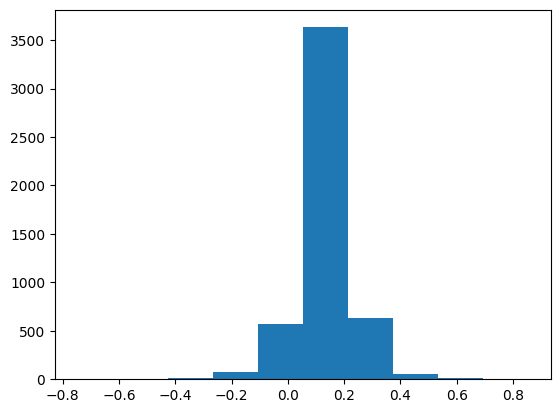

0.13138397


In [13]:
import matplotlib.pyplot as plt

localvol_trainhedge.compile(optimizer='adam', 
              loss='mean_squared_error')
localvol_trainlocvol.compile(optimizer='adam', 
              loss='mean_squared_error')
for i in range(3):
    localvol_trainhedge.fit(x=xtrain,y=ytrain, epochs=15,verbose=True)
    x = localvol_trainhedge.get_weights()
    localvol_trainlocvol.set_weights(x)
    localvol_trainlocvol.fit(x=xtrain,y=ytrain, epochs=5,verbose=True)
    plt.hist(localvol_trainhedge.predict(xtrain)[:,0])
    plt.show()
    print(np.mean(localvol_trainhedge.predict(xtrain)[:,0]))
    y = localvol_trainlocvol.get_weights()
    localvol_trainhedge.set_weights(y)

Hedging helps to reduce variance tremendously, whence we are able to go for a classical means square calibration approach, which is implemented below with a custom loss function.

In [14]:
def custom_loss(y_true,y_pred):
    return K.mean((K.mean(y_pred,axis=0)-K.mean(y_true,axis=0))**2)

localvol_trainlocvol.compile(optimizer='adam', 
              loss=custom_loss)

Train on 5000 samples
Epoch 1/10
5000/5000 [==============================] - 18s 4ms/sample - loss: 0.0083
Epoch 2/10
5000/5000 [==============================] - 0s 39us/sample - loss: 0.0054
Epoch 3/10
5000/5000 [==============================] - 0s 42us/sample - loss: 0.0032
Epoch 4/10
5000/5000 [==============================] - 0s 41us/sample - loss: 0.0017
Epoch 5/10
5000/5000 [==============================] - 0s 41us/sample - loss: 7.8535e-04
Epoch 6/10
5000/5000 [==============================] - 0s 39us/sample - loss: 3.3853e-04
Epoch 7/10
5000/5000 [==============================] - 0s 40us/sample - loss: 2.5586e-04
Epoch 8/10
5000/5000 [==============================] - 0s 42us/sample - loss: 3.0473e-04
Epoch 9/10
5000/5000 [==============================] - 0s 40us/sample - loss: 2.8582e-04
Epoch 10/10
5000/5000 [==============================] - 0s 41us/sample - loss: 3.2084e-04


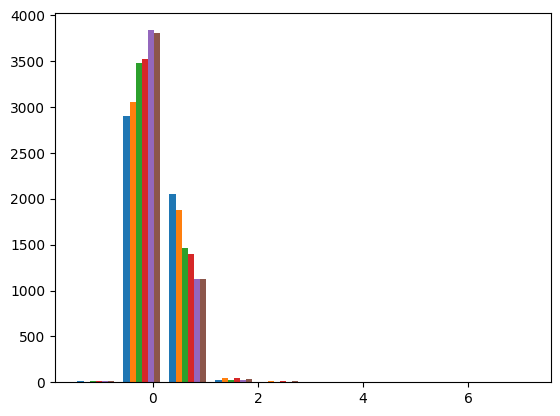

[0.22173198 0.23736441 0.18275331 0.2016785  0.15186192 0.17292   ]
Train on 5000 samples
Epoch 1/10
5000/5000 [==============================] - 0s 41us/sample - loss: 2.8492e-04
Epoch 2/10
5000/5000 [==============================] - 0s 42us/sample - loss: 2.3545e-04
Epoch 3/10
5000/5000 [==============================] - 0s 41us/sample - loss: 2.3886e-04
Epoch 4/10
5000/5000 [==============================] - 0s 40us/sample - loss: 2.2907e-04
Epoch 5/10
5000/5000 [==============================] - 0s 40us/sample - loss: 2.5307e-04
Epoch 6/10
5000/5000 [==============================] - 0s 39us/sample - loss: 2.0587e-04
Epoch 7/10
5000/5000 [==============================] - 0s 43us/sample - loss: 1.9895e-04
Epoch 8/10
5000/5000 [==============================] - 0s 43us/sample - loss: 2.2080e-04
Epoch 9/10
5000/5000 [==============================] - 0s 38us/sample - loss: 2.1664e-04
Epoch 10/10
5000/5000 [==============================] - 0s 42us/sample - loss: 2.0262e-04


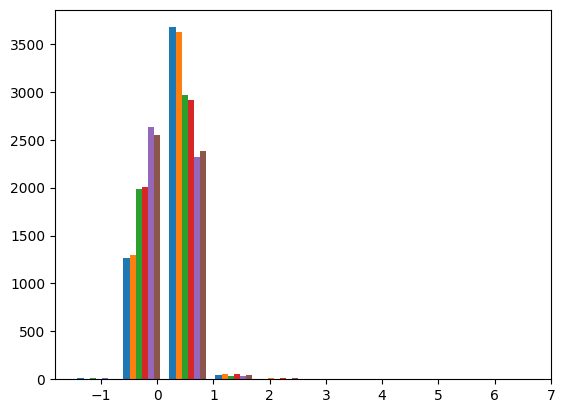

[0.21473044 0.22968242 0.17531323 0.19352703 0.14435904 0.16466965]
Train on 5000 samples
Epoch 1/10
5000/5000 [==============================] - 0s 69us/sample - loss: 2.1522e-04
Epoch 2/10
5000/5000 [==============================] - 0s 67us/sample - loss: 2.0486e-04
Epoch 3/10
5000/5000 [==============================] - 0s 39us/sample - loss: 2.5265e-04
Epoch 4/10
5000/5000 [==============================] - 0s 41us/sample - loss: 2.1909e-04
Epoch 5/10
5000/5000 [==============================] - 0s 39us/sample - loss: 2.1236e-04
Epoch 6/10
5000/5000 [==============================] - 0s 41us/sample - loss: 2.1168e-04
Epoch 7/10
5000/5000 [==============================] - 0s 38us/sample - loss: 2.0362e-04
Epoch 8/10
5000/5000 [==============================] - 0s 39us/sample - loss: 2.3353e-04
Epoch 9/10
5000/5000 [==============================] - 0s 41us/sample - loss: 2.1160e-04
Epoch 10/10
5000/5000 [==============================] - 0s 38us/sample - loss: 2.3829e-04


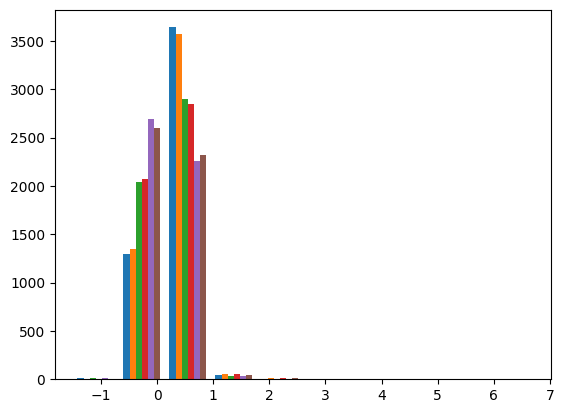

[0.21484031 0.22980413 0.17542966 0.19365549 0.14447585 0.16479957]
Train on 5000 samples
Epoch 1/10
5000/5000 [==============================] - 0s 40us/sample - loss: 2.0963e-04
Epoch 2/10
5000/5000 [==============================] - 0s 38us/sample - loss: 2.3473e-04
Epoch 3/10
5000/5000 [==============================] - 0s 38us/sample - loss: 1.9970e-04
Epoch 4/10
5000/5000 [==============================] - 0s 39us/sample - loss: 2.4753e-04
Epoch 5/10
5000/5000 [==============================] - 0s 39us/sample - loss: 2.3744e-04
Epoch 6/10
5000/5000 [==============================] - 0s 37us/sample - loss: 2.3015e-04
Epoch 7/10
5000/5000 [==============================] - 0s 47us/sample - loss: 2.0413e-04
Epoch 8/10
5000/5000 [==============================] - 0s 45us/sample - loss: 2.4657e-04
Epoch 9/10
5000/5000 [==============================] - 0s 40us/sample - loss: 2.0376e-04
Epoch 10/10
5000/5000 [==============================] - 0s 39us/sample - loss: 2.0802e-04


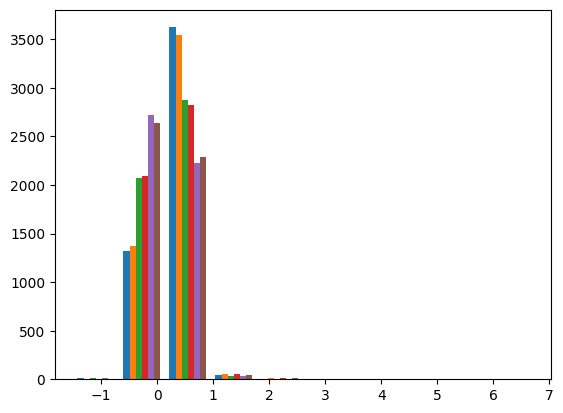

[0.21498594 0.22996448 0.17558116 0.19382177 0.14462587 0.1649647 ]
Train on 5000 samples
Epoch 1/10
5000/5000 [==============================] - 0s 39us/sample - loss: 2.2047e-04
Epoch 2/10
5000/5000 [==============================] - 0s 39us/sample - loss: 2.2511e-04
Epoch 3/10
5000/5000 [==============================] - 0s 42us/sample - loss: 2.2889e-04
Epoch 4/10
5000/5000 [==============================] - 0s 42us/sample - loss: 1.9784e-04
Epoch 5/10
5000/5000 [==============================] - 0s 39us/sample - loss: 2.0725e-04
Epoch 6/10
5000/5000 [==============================] - 0s 40us/sample - loss: 2.1572e-04
Epoch 7/10
5000/5000 [==============================] - 0s 41us/sample - loss: 2.1374e-04
Epoch 8/10
5000/5000 [==============================] - 0s 40us/sample - loss: 2.2545e-04
Epoch 9/10
5000/5000 [==============================] - 0s 41us/sample - loss: 1.9936e-04
Epoch 10/10
5000/5000 [==============================] - 0s 40us/sample - loss: 2.2069e-04


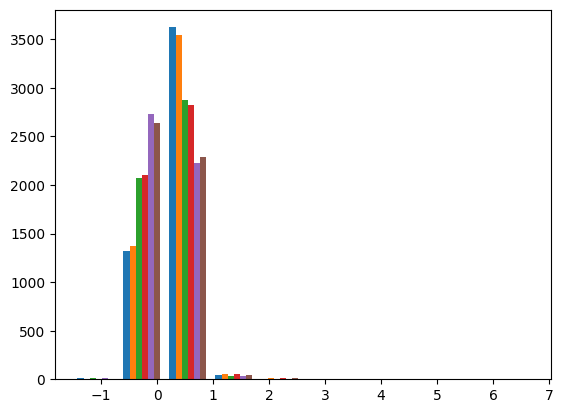

[0.21503706 0.23002036 0.17563362 0.19387895 0.14467752 0.16502108]
Train on 5000 samples
Epoch 1/10
5000/5000 [==============================] - 0s 75us/sample - loss: 2.1684e-04
Epoch 2/10
5000/5000 [==============================] - 0s 67us/sample - loss: 2.1068e-04
Epoch 3/10
5000/5000 [==============================] - 0s 68us/sample - loss: 2.3608e-04
Epoch 4/10
5000/5000 [==============================] - 0s 69us/sample - loss: 1.9432e-04
Epoch 5/10
5000/5000 [==============================] - 0s 67us/sample - loss: 1.8957e-04
Epoch 6/10
5000/5000 [==============================] - 0s 71us/sample - loss: 2.1273e-04
Epoch 7/10
5000/5000 [==============================] - 0s 55us/sample - loss: 2.4494e-04
Epoch 8/10
5000/5000 [==============================] - 0s 38us/sample - loss: 2.4780e-04
Epoch 9/10
5000/5000 [==============================] - 0s 44us/sample - loss: 2.2213e-04
Epoch 10/10
5000/5000 [==============================] - 0s 39us/sample - loss: 1.9797e-04


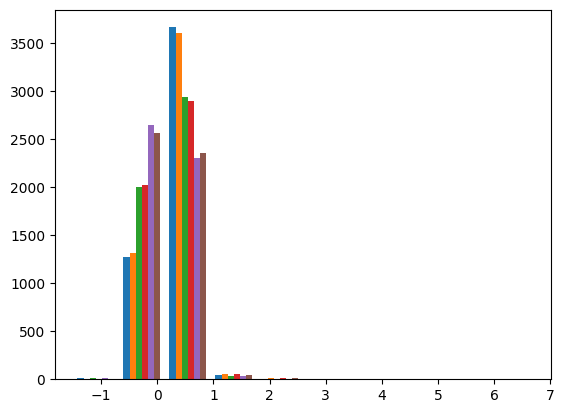

[0.214847   0.22981113 0.17543124 0.1936567  0.1444727  0.16479509]
Train on 5000 samples
Epoch 1/10
5000/5000 [==============================] - 0s 41us/sample - loss: 2.2953e-04
Epoch 2/10
5000/5000 [==============================] - 0s 38us/sample - loss: 2.2670e-04
Epoch 3/10
5000/5000 [==============================] - 0s 41us/sample - loss: 2.1648e-04
Epoch 4/10
5000/5000 [==============================] - 0s 42us/sample - loss: 2.2469e-04
Epoch 5/10
5000/5000 [==============================] - 0s 43us/sample - loss: 2.2246e-04
Epoch 6/10
5000/5000 [==============================] - 0s 40us/sample - loss: 2.2472e-04
Epoch 7/10
5000/5000 [==============================] - 0s 38us/sample - loss: 1.9168e-04
Epoch 8/10
5000/5000 [==============================] - 0s 42us/sample - loss: 2.3587e-04
Epoch 9/10
5000/5000 [==============================] - 0s 40us/sample - loss: 2.3339e-04
Epoch 10/10
5000/5000 [==============================] - 0s 39us/sample - loss: 2.3669e-04


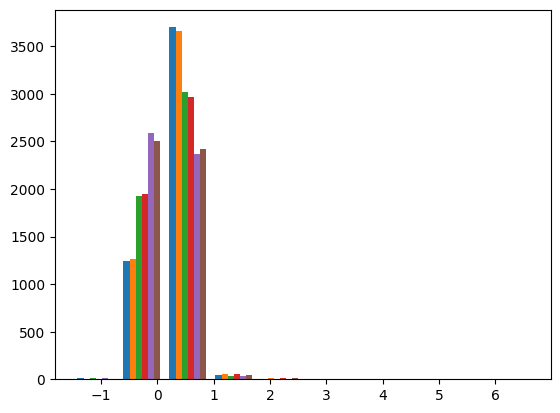

[0.21455254 0.22948939 0.175114   0.19330946 0.14414988 0.16444097]
Train on 5000 samples
Epoch 1/10
5000/5000 [==============================] - 0s 39us/sample - loss: 2.2292e-04
Epoch 2/10
5000/5000 [==============================] - 0s 40us/sample - loss: 2.1615e-04
Epoch 3/10
5000/5000 [==============================] - 0s 39us/sample - loss: 2.1389e-04
Epoch 4/10
5000/5000 [==============================] - 0s 39us/sample - loss: 2.3117e-04
Epoch 5/10
5000/5000 [==============================] - 0s 40us/sample - loss: 2.2755e-04
Epoch 6/10
5000/5000 [==============================] - 0s 40us/sample - loss: 2.0036e-04
Epoch 7/10
5000/5000 [==============================] - 0s 39us/sample - loss: 2.4976e-04
Epoch 8/10
5000/5000 [==============================] - 0s 39us/sample - loss: 2.1121e-04
Epoch 9/10
5000/5000 [==============================] - 0s 40us/sample - loss: 2.2109e-04
Epoch 10/10
5000/5000 [==============================] - 0s 39us/sample - loss: 2.2861e-04


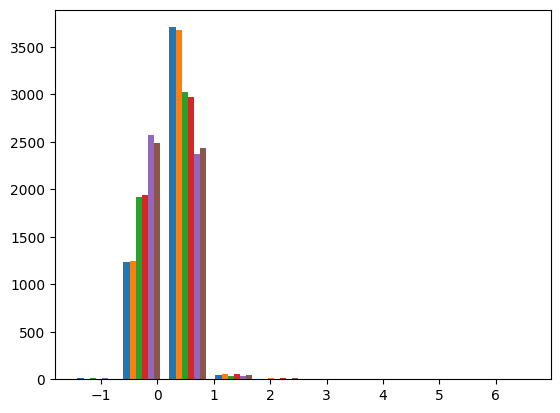

[0.21452011 0.22945398 0.17507353 0.1932652  0.144105   0.16439138]
Train on 5000 samples
Epoch 1/10
5000/5000 [==============================] - 0s 40us/sample - loss: 2.2478e-04
Epoch 2/10
5000/5000 [==============================] - 0s 40us/sample - loss: 2.3762e-04
Epoch 3/10
5000/5000 [==============================] - 0s 40us/sample - loss: 1.9527e-04
Epoch 4/10
5000/5000 [==============================] - 0s 67us/sample - loss: 2.5208e-04
Epoch 5/10
5000/5000 [==============================] - 0s 72us/sample - loss: 2.5192e-04
Epoch 6/10
5000/5000 [==============================] - 0s 70us/sample - loss: 2.0130e-04
Epoch 7/10
5000/5000 [==============================] - 0s 73us/sample - loss: 2.1245e-04
Epoch 8/10
5000/5000 [==============================] - 0s 74us/sample - loss: 2.0306e-04
Epoch 9/10
5000/5000 [==============================] - 0s 68us/sample - loss: 2.6556e-04
Epoch 10/10
5000/5000 [==============================] - 0s 71us/sample - loss: 2.5875e-04


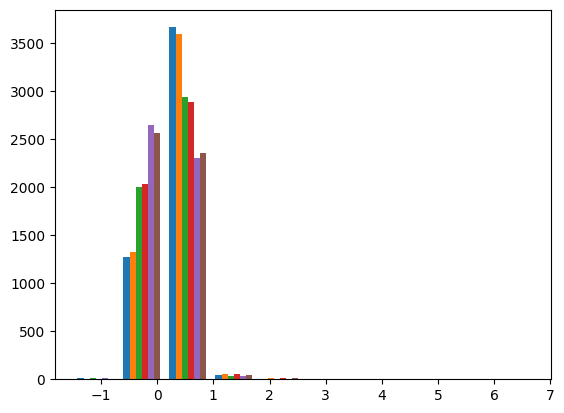

[0.21495977 0.22993726 0.17553735 0.1937739  0.14456914 0.16490209]
Train on 5000 samples
Epoch 1/10
5000/5000 [==============================] - 0s 40us/sample - loss: 2.0855e-04
Epoch 2/10
5000/5000 [==============================] - 0s 40us/sample - loss: 2.7498e-04
Epoch 3/10
5000/5000 [==============================] - 0s 41us/sample - loss: 2.1765e-04
Epoch 4/10
5000/5000 [==============================] - 0s 38us/sample - loss: 2.0303e-04
Epoch 5/10
5000/5000 [==============================] - 0s 40us/sample - loss: 2.8255e-04
Epoch 6/10
5000/5000 [==============================] - 0s 42us/sample - loss: 2.8986e-04
Epoch 7/10
5000/5000 [==============================] - 0s 40us/sample - loss: 2.4869e-04
Epoch 8/10
5000/5000 [==============================] - 0s 39us/sample - loss: 2.3397e-04
Epoch 9/10
5000/5000 [==============================] - 0s 40us/sample - loss: 2.4019e-04
Epoch 10/10
5000/5000 [==============================] - 0s 40us/sample - loss: 1.9668e-04


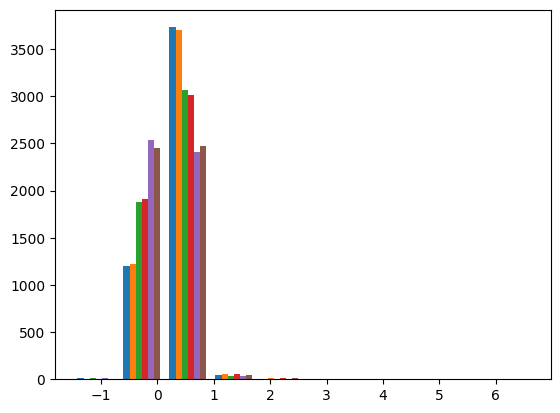

[0.21479392 0.22975561 0.17534544 0.19356276 0.14436378 0.16467471]


In [15]:
for i in range(10):
    localvol_trainlocvol.fit(x=xtrain,y=ytrain, epochs=10, verbose=True,batch_size=10**3)
    plt.hist(localvol_trainlocvol.predict(xtrain)[:,:])
    plt.show()
    print(np.mean(localvol_trainlocvol.predict(xtrain)[:,:],axis=0))

In [16]:
Ltest = 10**6

xtest =([np.ones(Ltest)] + [np.zeros(Ltest) for key in keylist]+
         [np.random.normal(0,1,Ltest) for i in range(N)]+
         [np.ones(Ltest) for i in range(N)])

ytest=np.zeros((Ltest,len(P.keys())))
for i in range(Ltest):
    for l in range(len(P.keys())):
        key = keylist[l]
        ytest[i,l]= P[key]

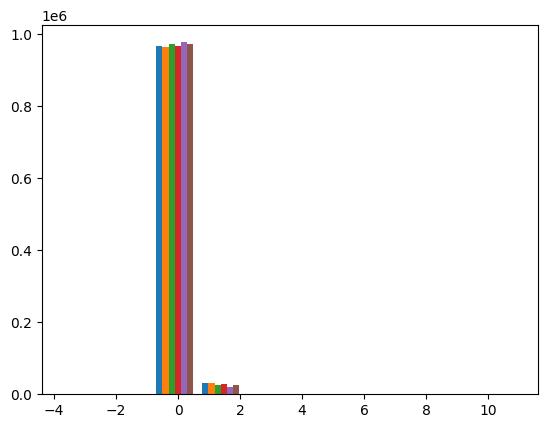

Calibrated values: [0.21280186 0.22761832 0.17333622 0.19056234 0.1420466  0.16072236]
Ground truth: [0.20042534, 0.23559685, 0.16312157, 0.20771958, 0.13154241, 0.18236567]


In [17]:
plt.hist(localvol_trainlocvol.predict(xtest)[:,:])
plt.show()
print('Calibrated values:', np.mean(localvol_trainlocvol.predict(xtest)[:,:],axis=0))
print('Ground truth:', [P[key] for key in keylist])

In [18]:
P

{(0.9, 0.5): 0.20042534,
 (0.9, 1.0): 0.23559685,
 (1.0, 0.5): 0.16312157,
 (1.0, 1.0): 0.20771958,
 (1.1, 0.5): 0.13154241,
 (1.1, 1.0): 0.18236567}

... not so bad.

In [ ]:
#maturities = [0.1, 0.25, 0.5, 1.0]
#strikes = [0.8, 0.9, 1.0, 1.1, 1.2]
#for T in maturities:
#    for K in strikes:
#         P[(K,T)] = 1.0
#Lgen = 10**6
#keylist = P.keys()
#xgen =([np.ones(Lgen)] + [np.zeros(Lgen) for key in keylist]+
#       [np.random.normal(0,1,Lgen) for i in range(N)]+
#       [np.ones(Lgen) for i in range(N)])
#
#ygen=np.mean(localvol_trainlocvol.predict(xgen)[:,:],axis=0)
#for l in range(len(P.keys())):
#    key = keylist[l]
#    P[key] = ygen[1,l]